In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [310]:
# read data
tmp = pd.read_excel('EURHUF_TRB.xlsx')
tmp = tmp.rename(columns={'Date (GMT)': 'index'})
df = tmp['Last']
df.index = tmp['index']
df.head()

index
2022-01-25 16:00:00    358.460
2022-01-25 17:00:00    359.060
2022-01-25 18:00:00    359.155
2022-01-25 19:00:00    358.865
2022-01-25 20:00:00    358.515
Name: Last, dtype: float64

In [429]:
class Bollinger:
    
    def __init__(self, data:pd.Series, sma_period:int=20, std_multiplier:float=2):
        self.data = pd.DataFrame(data.rename('Price'))
        self._sma_period = sma_period
        self._std_multiplier = std_multiplier
        
        self.data[f'Singe Moving Average (period={self._sma_period})'] = self.data.rolling(self._sma_period).mean()
        self.data['std'] = self.data['Price'].rolling(self._sma_period).std()
        self.data['Bollinger lower bound'] = self.data[f'Singe Moving Average (period={self._sma_period})'] - self._std_multiplier * self.data['std']
        self.data['Bollinger upper bound'] = self.data[f'Singe Moving Average (period={self._sma_period})'] + self._std_multiplier * self.data['std']
        self.data['Upper breakpoint'] = self.data[(self.data['Price']>self.data['Bollinger upper bound'])]['Price']
        self.data['Lower breakpoint'] = self.data[(self.data['Price']<self.data['Bollinger lower bound'])]['Price']
        
        self.data_length = self.data.shape[0]
        self.ext_up = self.data['Upper breakpoint'].count()
        self.ext_low = self.data['Lower breakpoint'].count()
        
        
    def statistics(self):
        col1_length = 35
        print(f"{'Length of time series: ' :>{col1_length}}{self.data_length}")
        print(f"{'SMA period: ':>{col1_length}}{self._sma_period}")
        print(f"{'Std multiplier: ':>{col1_length}}{self._std_multiplier}")
        print(f"{'Number of upper breakpoints: ':>{col1_length}}{self.ext_up} ({round(100*self.ext_up/self.data_length,2)}%)")
        print(f"{'Number of lower breakpoints: ':>{col1_length}}{self.ext_low} ({round(100*self.ext_low/self.data_length,2)}%)")
        print(f"{'Ratio of breakpoints: ':>{col1_length}}{round((self.ext_up+self.ext_low)/self.data_length*100,2)}%")
        
        
    def plot(self, plot_sma:bool=True, plot_bollinger_bound:bool=True, plot_long_sma:int=None, plot_breakpoints:bool=True):
        fig, ax = plt.subplots(1,1,figsize=(16,16))
        columns = ['Price']
        
        if plot_sma:
            columns.append(f'Singe Moving Average (period={self._sma_period})')
        
        if plot_bollinger_bound:
            columns.append('Bollinger lower bound')
            columns.append('Bollinger upper bound')
        
        if plot_long_sma:
            self.data[f'Long SMA (period={plot_long_sma})'] = self.data['Price'].rolling(plot_long_sma).mean()
            columns.append(f'Long SMA (period={plot_long_sma})')
        
        if plot_breakpoints:
            columns.append('Upper breakpoint')
            columns.append('Lower breakpoint')
            
        # Plot
        sns.lineplot(data=self.data[columns], ax=ax, legend=False)
        
        # Style
        ax.lines[columns.index('Price')].set(linestyle='-', color="C0")
        
        if plot_sma:
            ax.lines[columns.index(f'Singe Moving Average (period={self._sma_period})')].set(linestyle='-', color='orange')
        
        if plot_bollinger_bound:
            ax.fill_between(self.data.index, self.data['Bollinger lower bound'], self.data['Bollinger upper bound'], alpha=0.1)
            ax.lines[columns.index('Bollinger lower bound')].set(linestyle='--', color='green')
            ax.lines[columns.index('Bollinger upper bound')].set(linestyle='--', color='red')
        
        if plot_long_sma:
            ax.lines[columns.index(f'Long SMA (period={plot_long_sma})')].set(linestyle='-', color='C9')
        
        if plot_breakpoints:
            ax.lines[columns.index('Upper breakpoint')].set(linestyle='', marker='o', markersize=10, color='red')
            ax.lines[columns.index('Lower breakpoint')].set(linestyle='', marker='o', markersize=10, color='green')
              
        # Legend
        ax.legend(columns)

In [463]:
b = Bollinger(df.tail(1000), 20, 2.5)

In [464]:
b.data

,Price,Singe Moving Average (period=20),std,Bollinger lower bound,Bollinger upper bound,Upper breakpoint,Lower breakpoint
index,,,,,,,
2022-11-25 22:00:00,408.120,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-28 02:00:00,408.585,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-28 03:00:00,409.070,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-28 04:00:00,409.080,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-28 05:00:00,409.085,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-01-25 12:00:00,388.845,389.08825,0.438683,387.991542,390.184958,NaN,NaN
2023-01-25 13:00:00,388.985,389.05000,0.410385,388.024038,390.075962,NaN,NaN
2023-01-25 14:00:00,389.250,389.06250,0.412583,388.031042,390.093958,NaN,NaN


In [465]:
b.statistics()

            Length of time series: 1000
                       SMA period: 20
                   Std multiplier: 2.5
      Number of upper breakpoints: 35 (3.5%)
      Number of lower breakpoints: 16 (1.6%)
             Ratio of breakpoints: 5.1%


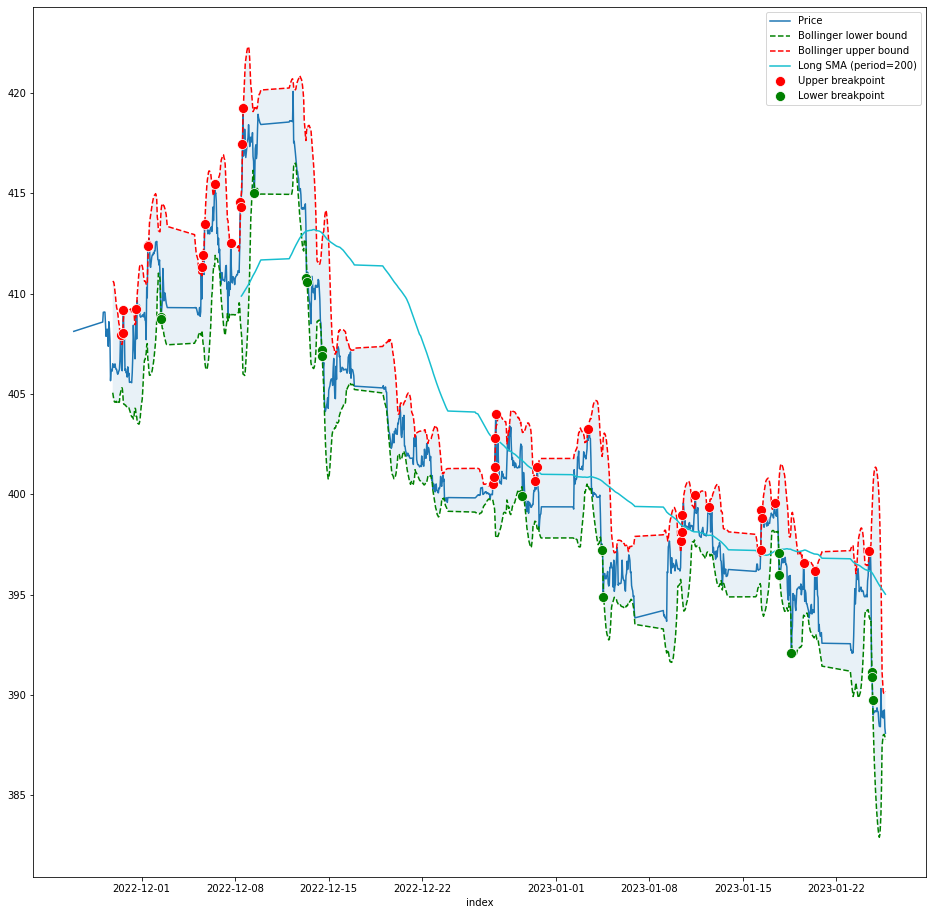

In [468]:
b.plot(plot_bollinger_bound=True,
       plot_sma=False,
       plot_breakpoints=True,
       plot_long_sma=200)

In [454]:
def calc_profit(df, balance:int=500):
    
    print(df.head())
    for index, row in df.head().iterrows():
        print(row)
    
calc_profit(b.data[['Lower breakpoint','Upper breakpoint']])

                     Lower breakpoint  Upper breakpoint
index                                                  
2022-12-27 08:00:00               NaN               NaN
2022-12-27 09:00:00               NaN               NaN
2022-12-27 10:00:00               NaN               NaN
2022-12-27 11:00:00               NaN               NaN
2022-12-27 12:00:00               NaN               NaN
Lower breakpoint   NaN
Upper breakpoint   NaN
Name: 2022-12-27 08:00:00, dtype: float64
Lower breakpoint   NaN
Upper breakpoint   NaN
Name: 2022-12-27 09:00:00, dtype: float64
Lower breakpoint   NaN
Upper breakpoint   NaN
Name: 2022-12-27 10:00:00, dtype: float64
Lower breakpoint   NaN
Upper breakpoint   NaN
Name: 2022-12-27 11:00:00, dtype: float64
Lower breakpoint   NaN
Upper breakpoint   NaN
Name: 2022-12-27 12:00:00, dtype: float64
